In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error

In [2]:
# Load the Brent oil data
column_names = ["Date", "OilPrice"]
brent_data = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls", sheet_name=1, skiprows=4, engine='xlrd', names=column_names)
brent_data.dropna(inplace=True)
brent_data['Date'] = pd.to_datetime(brent_data['Date'])
brent_data.set_index('Date', inplace=True)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
brent_data['normalized_oil_prices'] = scaler.fit_transform(brent_data[['OilPrice']])

In [3]:
# Train-test split
split_date = pd.to_datetime("2010-01-01")
cutoff_date = pd.to_datetime("2023-01-01")

train_data = brent_data.loc[split_date:cutoff_date]['normalized_oil_prices']
test_data = brent_data.loc[cutoff_date:]['normalized_oil_prices']
test_real = brent_data.loc[cutoff_date:]['OilPrice']
test_dates_full = brent_data.loc[cutoff_date:].index

In [4]:
# Function to create sequences for LSTM input
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

# Define sequence length (e.g., 60 days)
seq_length = 60
train_sequences = create_sequences(train_data.values, seq_length)
test_sequences = create_sequences(test_data.values, seq_length)

In [5]:
# Split sequences into input (X) and output (y)
X_train = train_sequences[:, :-1]
y_train = train_sequences[:, -1]

X_test = test_sequences[:, :-1]
y_test = test_sequences[:, -1]

# Reshape for LSTM input [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Adjust the test dates to account for the sequence length
test_dates = test_dates_full[seq_length:]

In [7]:
# Build the Stacked LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))

# Second LSTM layer
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))

# Third LSTM layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))

# Output Dense layer for prediction
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 24s 191ms/step - loss: 0.0256 - val_loss: 7.8898e-04
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 158ms/step - loss: 0.0033 - val_loss: 6.9763e-04
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 0.0027 - val_loss: 7.6519e-04
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - loss: 0.0027 - val_loss: 9.9682e-04
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - loss: 0.0023 - val_loss: 5.7700e-04
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - loss: 0.0021 - val_loss: 5.6669e-04
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - loss: 0.0020 - val_loss: 4.9298e-04
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 21s 156ms/step - loss: 0.0019 - val_loss

In [8]:
# Predict on test data
predicted_oil_prices = model.predict(X_test)
predicted_oil_prices = scaler.inverse_transform(predicted_oil_prices)  # Rescale to original values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), predicted_oil_prices))
print(f'Root Mean Squared Error: {rmse}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Root Mean Squared Error: 2.420721253405114


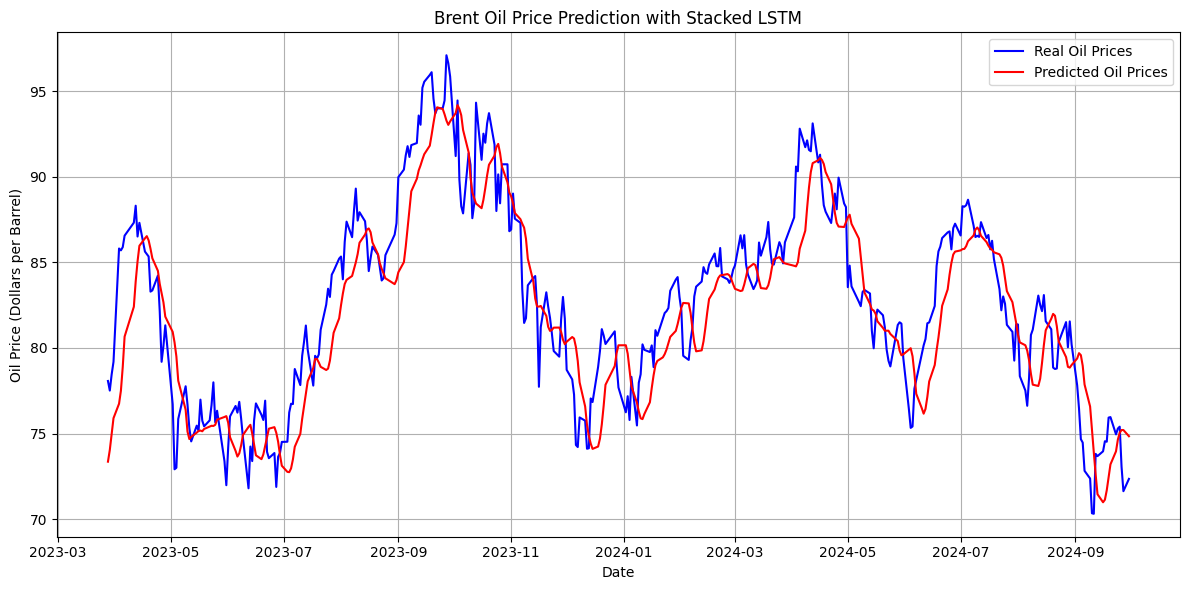

In [9]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(test_dates, test_real[seq_length:], label='Real Oil Prices', color='blue')
plt.plot(test_dates, predicted_oil_prices, label='Predicted Oil Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Oil Price (Dollars per Barrel)')
plt.title('Brent Oil Price Prediction with Stacked LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()